## Digit Recognizer
Valentin Chomel
30/01/2019

### Introduction 
Il s’agit d’un réseau de neurones à convolution séquentielle à 5 couches pour la reconnaissance des chiffres, formé sur le dataset MNIST. Il est construit avec l'API keras (backend Tensorflow). Tout d'abord, je vais préparer les données (images manuscrites à chiffres), puis je me concentrerai sur la modélisation et l'évaluation CNN.

For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.

Ce notebook se décompose en 3 parties :

1 - La préparation des données
2 - La modélisation et l'évaluation du CNN
3 - Résultats

In [116]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

### Preparation des données
#### Chargement des données

In [117]:
# Load
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

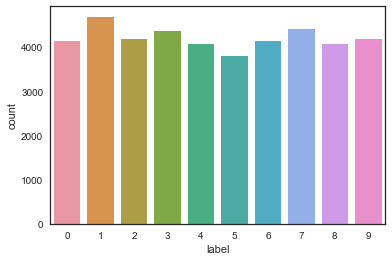

In [118]:
Y_train = train["label"]

# Supprimer la colonne 'label'
X_train = train.drop(labels = ["label"],axis = 1) 

# Liberation d'espace
#del train 

# Affichage du nombre d'observations dans chaque catégorie à l'aide de barres.
g = sns.countplot(Y_train)

Y_train.value_counts()

On note que les comptes sont similaires pour les 10 chiffres.

#### Vérifier les valeurs nulles et manquantes

In [119]:
# Vérification des données
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [120]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Il n'y a pas de valeurs manquantes dans les datasets train et test.

#### Normalisation

Normalisation en niveaux de gris pour réduire l'effet des différences d'éclairage.

De plus, le CNN converge plus rapidement sur les données [0..1] que sur [0..255].

In [121]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

TypeError: Could not operate 255.0 with block values 

In [ ]:
# Remodeler l’image en 3 dimensions (height = 28px, width = 28px , canal = 1)

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Les images de train et test (28px x 28px) ont été stocké dans pandas.Dataframe sous forme de vecteurs 1D de 784 valeurs. Nous remodelons toutes les données en matrices 3D 28x28x1.

Keras nécessite une dimension supplémentaire à la fin qui correspond aux canaux. Les images MNIST ont une échelle de gris et n'utilisent qu'un seul canal. 
Note : Pour les images RVB, il y a 3 canaux, nous aurions remodelé les vecteurs 784px en matrices 3D 28x28x3.

#### Codage de label

In [ ]:
# Encodage one-hot des labels (ex: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Les étiquettes sont des nombres à 10 chiffres de 0 à 9. Nous devons coder ces étiquettes en one-hot (ex: 2 -> [0,0,1,0,0,0,0,0,0,0]).

#### Entraiment divisé et validation set

In [ ]:
# Définition du random seed
random_seed = 2

# Séparer le train set et le jeu de validation pour l'ajustement
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

On cinde le train set en deux parties: une petite fraction (10%) est devenue le jeu de validation pour lequel le modèle est évalué et le reste (90%) est utilisé pour former le modèle.

Comme nous disposons de 42 000 images d'apprentissage étiquettées (voir dessus), une scission aléatoire du train ne provoque pas la surreprésentation de certaines étiquettes dans l'ensemble de validation. 

Attention : avec certains ensembles de données non équilibrés, une simple division aléatoire pourrait entraîner une évaluation inexacte lors de la validation.
Pour éviter cela, utiliser l’option stratify = True dans la fonction train_test_split (uniquement pour les versions> = 0.17 de Sklearn).

Exemple (image et étiquette) :

In [ ]:
# Un exemple
g = plt.imshow(X_train[0][:,:,0])


### CNN

#### Définition du modèle

API séquentielle Keras, où il suffit d'ajouter une couche à la fois, à partir de l'entrée.

Le premier est la couche convolutionnelle (Conv2D). C'est comme un ensemble de filtres pouvant être appris. J'ai choisi de définir 32 filtres pour les deux premières couches de conv2D et 64 filtres pour les deux derniers. Chaque filtre transforme une partie de l'image (définie par la taille du noyau) à l'aide du filtre de noyau. La matrice de filtrage du noyau est appliquée à l’ensemble de l’image. Les filtres peuvent être vus comme une transformation de l'image.

Le CNN peut isoler les caractéristiques utiles partout de ces images transformées (cartes de caractéristiques).

La deuxième couche importante de CNN est la couche de mise en commun (MaxPool2D). Cette couche sert simplement de filtre de sous-échantillonnage. Il regarde les 2 pixels voisins et choisit la valeur maximale. Celles-ci sont utilisées pour réduire les coûts de calcul et, dans une certaine mesure, réduire également le surajustement. Nous devons choisir la taille de la mise en commun (c'est-à-dire la taille de la zone mise en commun à chaque fois), plus la dimension de mise en commun est élevée, plus le sous-échantillonnage est important.

Combinant des couches de convolution et de regroupement, CNN peut combiner des fonctionnalités locales et apprendre des fonctionnalités plus globales de l'image.

L'abandon est une méthode de régularisation dans laquelle une proportion de noeuds de la couche est ignorée de manière aléatoire (en définissant leur poids à zéro) pour chaque échantillon d'apprentissage. Cela laisse tomber au hasard une proposition du réseau et oblige le réseau à apprendre les fonctionnalités de manière distribuée. Cette technique améliore également la généralisation et réduit le surajustement.

'relu' est le redresseur (fonction d'activation max (0, x). La fonction d'activation du redresseur permet d'ajouter une non-linéarité au réseau.

La couche Flatten est utilisée pour convertir les cartes de caractéristiques finales en un seul vecteur 1D. Cette étape d'aplatissement est nécessaire pour que utiliser des couches entièrement connectées après certaines couches convolutionnelles / maxpool. Il combine toutes les caractéristiques locales trouvées des couches convolutionnelles précédentes.

En fin de compte, j’ai utilisé les caractéristiques de deux couches (Dense) entièrement connectées, c’est-à-dire un classifieur artificiel de réseaux neuronaux (ANN). Dans la dernière couche (Dense (10, activation = "softmax")), la distribution de sortie nette de la probabilité de chaque classe.

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

#### Définir l'optimiseur et l'annealer

Une fois nos couches ajoutées au modèle, nous devons définir une fonction de score, une fonction de perte et un algorithme d'optimisation.

Nous définissons la fonction de perte pour mesurer la performance médiocre de notre modèle sur des images avec des étiquettes connues. C'est le taux d'erreur entre les étiquettes observées et celles prédites. Nous utilisons un formulaire spécifique pour les classifications catégoriques (> 2 classes) appelé "categorical_crossentropy".

La fonction la plus importante est l'optimiseur. Cette fonction améliorera de manière itérative les paramètres (filtres les valeurs du noyau, les poids et le biais des neurones ...) afin de minimiser la perte.

J'ai choisi RMSprop (avec les valeurs par défaut), c'est un optimiseur très efficace. La mise à jour RMSProp ajuste la méthode Adagrad de manière très simple afin de réduire son taux d’apprentissage agressif et décroissant de façon monotone. Nous aurions aussi pu utiliser l'optimiseur de descente de gradient stochastique ('sgd'), mais il est plus lent que RMSprop.

La fonction métrique "precision" est utilisée pour évaluer les performances de notre modèle. Cette fonction métrique est similaire à la fonction de perte, sauf que les résultats de l'évaluation métrique ne sont pas utilisés lors de la formation du modèle (uniquement pour l'évaluation).

In [ ]:
# Définition de l'optimiseur
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compilation du modele
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Afin de faire converger l'optimiseur plus rapidement et au plus près du minimum global de la fonction de perte, j'ai utilisé une méthode de recuit du taux d'apprentissage (LR).

Le LR est l’étape par laquelle l’optimiseur parcourt le «paysage des pertes». Plus le LR est élevé, plus les marches sont grandes et plus la convergence est rapide. Cependant, l'échantillonnage est très faible avec un LR élevé et l'optimiseur pourrait probablement tomber dans un minimum local.

Il est préférable d’avoir un taux d’apprentissage décroissant pendant la formation pour atteindre efficacement le minimum global de la fonction de perte.

Pour conserver l'avantage du temps de calcul rapide avec un LR élevé, on diminue le LR de manière dynamique toutes les X étapes (époque) en fonction de son utilité (lorsque la précision n'est pas améliorée).

Avec la fonction ReduceLROnPlateau de Keras.callbacks, je choisis de réduire de moitié le LR si la précision n’est pas améliorée au bout de 3 époques.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

#### Data augmentation

Afin d'éviter tout problème de surajustement, nous devons développer artificiellement notre ensemble de données numériques manuscrites. Nous pouvons rendre votre jeu de données existant encore plus grand. L'idée est de modifier les données d'apprentissage avec de petites transformations pour reproduire les variations qui se produisent lorsque quelqu'un écrit un chiffre.

Par exemple, le nombre n'est pas centré L'échelle n'est pas la même (certains écrivent avec de grands / petits nombres) L'image est pivotée ...

Les approches qui modifient les données d'apprentissage de manière à modifier la représentation du tableau tout en conservant le même libellé sont appelées techniques d'augmentation de données. Certaines augmentations populaires utilisées par les utilisateurs sont les niveaux de gris, les inversions horizontales, les inversions verticales, les cultures aléatoires, les tremblements de couleur, les translations, les rotations et bien plus encore.

En appliquant seulement quelques-unes de ces transformations à nos données de formation, nous pouvons facilement doubler ou tripler le nombre d'exemples de formation et créer un modèle très robuste.

L'amélioration est importante:

Sans augmentation des données, j'ai obtenu une précision de 98,114%
Avec l'augmentation des données, j'ai atteint 99,67% de précision

In [ ]:
# Sans augmentation des données, j'ai obtenu une précision de 0,98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [ ]:
# Avec augmentation des données pour éviter les surajustements (précision 0,99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

Pour l'augmentation des données, j'ai choisi de:

Faire pivoter au hasard des images d'entraînement de 10 degrés
Zoomer au hasard de 10% sur certaines images d'entraînement
Décalage aléatoire des images horizontalement de 10% de la largeur
Décalage aléatoire des images verticalement de 10% de la hauteur
Je n'ai pas appliqué vertical_flip ni horizontal_flip, car cela aurait pu entraîner une classification erronée des nombres symétriques tels que 6 et 9.

Une fois que notre modèle est prêt, nous ajustons le jeu de données de formation.


In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

### Évaluer le modèle

#### Courbes de formation et de validation

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Le modèle atteint une précision de près de 99% (98,7 +%) sur l'ensemble de données de validation après 2 époques. La précision de la validation est supérieure à la précision de la formation presque toutes les heures pendant la formation. Cela signifie que notre modèle ne suraliment pas le kit d’entraînement.

Notre modèle est bien formé !

#### Matrice de confusion

La matrice de confusion peut être très utile pour voir les inconvénients de votre modèle.
Je trace la matrice de confusion des résultats de validation.

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Nous pouvons voir ici que notre CNN fonctionne très bien sur tous les chiffres avec peu d’erreurs compte tenu de la taille de l’ensemble de validation (4 200 images).

Cependant, il semble que notre CNN ait quelques problèmes avec les chiffres 4, mais ils sont mal classés en 9. Il est parfois très difficile de saisir la différence entre 4 et 9 lorsque les courbes sont lisses.

Examinons les erreurs.

Je veux voir les erreurs les plus importantes. Pour cela, je dois connaître la différence entre les probabilités de valeur réelle et celles prédites dans les résultats.

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Les erreurs les plus importantes sont aussi les plus intrigantes.

Pour ces six cas, le modèle n'est pas ridicule. Certaines de ces erreurs peuvent aussi être commises par des humains, en particulier pour un 9 très proche d'un 4. Les 9 derniers sont également très trompeurs, il me semble que c'est un 0.

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)